In [1]:
import sys
sys.path.append('../')
from src.data import SegmentationDataMap
from nuscenes.nuscenes import NuScenes
import torch

import matplotlib.pyplot as plt
import matplotlib as mpl
from pyquaternion import Quaternion
import numpy as np
from src.tools import get_local_map
import cv2

### Parameters

In [2]:
version='mini'
dataroot='/home/ruslan/datasets/nuscenes'
gpuid = 0

H=900
W=1600
resize_lim=(0.193, 0.225)
final_dim=(128, 352)
bot_pct_lim=(0.0, 0.22)
rot_lim=(-5.4, 5.4)
rand_flip=True
ncams=1
max_grad_norm=5.0
pos_weight=2.13

xbound=[-32.0, 32.0, 0.125]
ybound=[-32.0, 32.0, 0.125]
zbound=[-10.0, 10.0, 20.0]
dbound=[4.0, 45.0, 1.0]

bsz=1
nworkers=10
lr=1e-3
weight_decay=1e-7

grid_conf = {
    'xbound': xbound,
    'ybound': ybound,
    'zbound': zbound,
    'dbound': dbound,
}

cams = ['CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT',
        'CAM_BACK_LEFT', 'CAM_BACK', 'CAM_BACK_RIGHT']
# cams = ['CAM_FRONT', 'CAM_BACK']

data_aug_conf = {
                'resize_lim': resize_lim,
                'final_dim': final_dim,
                'rot_lim': rot_lim,
                'H': H, 'W': W,
                'rand_flip': rand_flip,
                'bot_pct_lim': bot_pct_lim,
                'cams': cams,
                'Ncams': ncams,
                }


### Load data

In [3]:
from src.tools import get_nusc_maps

nusc = NuScenes(version='v1.0-{}'.format(version),
                dataroot=dataroot,  # os.path.join(dataroot, version),
                verbose=False)

map_folder = dataroot
nusc_maps = get_nusc_maps(map_folder)

valdata = SegmentationDataMap(nusc_maps, nusc, is_train=False, data_aug_conf=data_aug_conf, grid_conf=grid_conf)
traindata = SegmentationDataMap(nusc_maps, nusc, is_train=True, data_aug_conf=data_aug_conf, grid_conf=grid_conf)

NuscData: 81 samples. Split: val.
                   Augmentation Conf: {'resize_lim': (0.193, 0.225), 'final_dim': (128, 352), 'rot_lim': (-5.4, 5.4), 'H': 900, 'W': 1600, 'rand_flip': True, 'bot_pct_lim': (0.0, 0.22), 'cams': ['CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT', 'CAM_BACK_LEFT', 'CAM_BACK', 'CAM_BACK_RIGHT'], 'Ncams': 1}
NuscData: 323 samples. Split: train.
                   Augmentation Conf: {'resize_lim': (0.193, 0.225), 'final_dim': (128, 352), 'rot_lim': (-5.4, 5.4), 'H': 900, 'W': 1600, 'rand_flip': True, 'bot_pct_lim': (0.0, 0.22), 'cams': ['CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT', 'CAM_BACK_LEFT', 'CAM_BACK', 'CAM_BACK_RIGHT'], 'Ncams': 1}


In [4]:
len(traindata), len(valdata)

(323, 81)

### Explore data

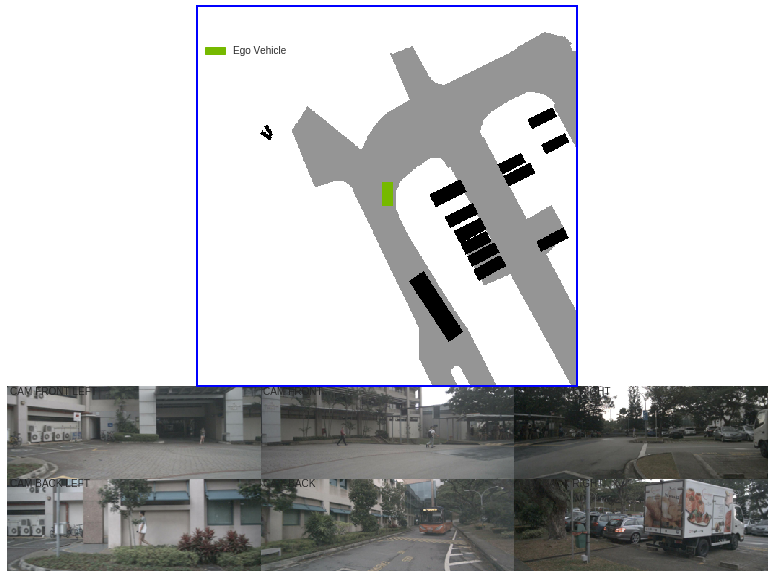

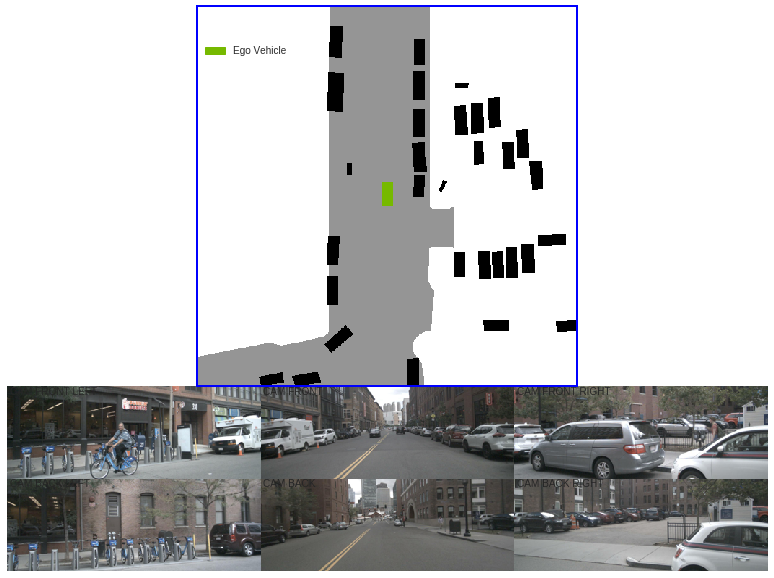

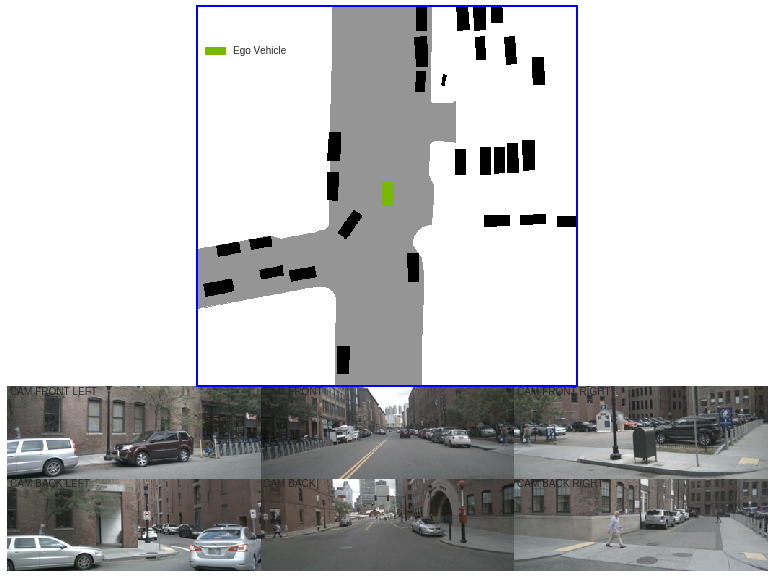

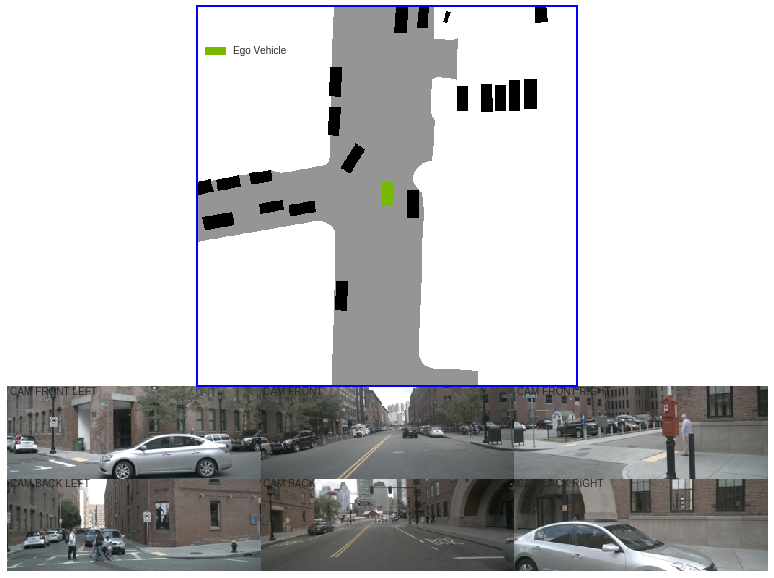

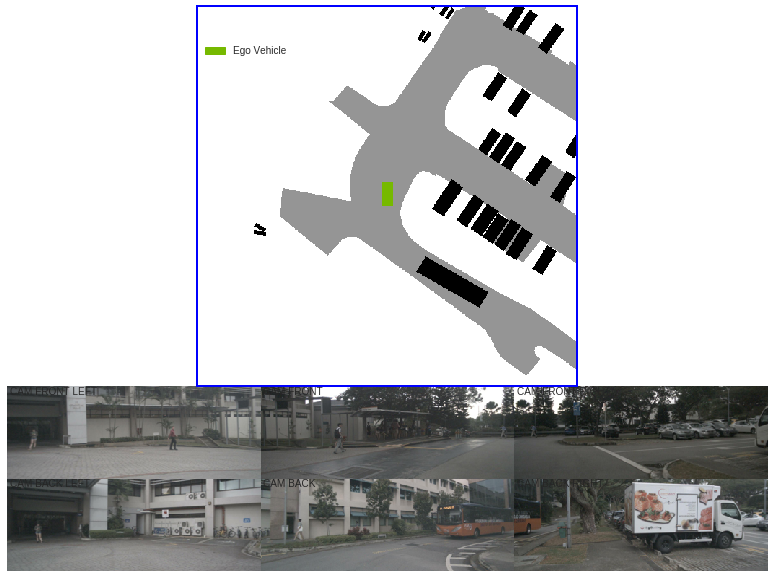

In [5]:
from src.tools import (ego_to_cam, get_only_in_img_mask, denormalize_img,
                    SimpleLoss, get_val_info, add_ego, gen_dx_bx,
                    get_nusc_maps, plot_nusc_map)
from PIL import Image
import matplotlib.patches as mpatches
%matplotlib inline

dx, bx, _ = gen_dx_bx(grid_conf['xbound'], grid_conf['ybound'], grid_conf['zbound'])
dx, bx = dx[:2].numpy(), bx[:2].numpy()

data = valdata

for counter in np.random.choice(range(len(data)), 5):
    imgs, rots, trans, intrins, post_rots, post_trans, map_binimg = data[counter]

    val = 0.01
    fH, fW = final_dim
    fig = plt.figure(figsize=(3*fW*val, (1.5*fW + 2*fH)*val))
    gs = mpl.gridspec.GridSpec(3, 3, height_ratios=(1.5*fW, fH, fH))
    gs.update(wspace=0.0, hspace=0.0, left=0.0, right=1.0, top=1.0, bottom=0.0)

    plt.clf()
    for imgi, img in enumerate(imgs):
        ax = plt.subplot(gs[1 + imgi // 3, imgi % 3])
        showimg = denormalize_img(img)
        # flip the bottom images
        if imgi > 2:
            showimg = showimg.transpose(Image.FLIP_LEFT_RIGHT)
        plt.imshow(showimg)
        plt.axis('off')
        plt.annotate(cams[imgi].replace('_', ' '), (0.01, 0.92), xycoords='axes fraction')

    ax = plt.subplot(gs[0, :])
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    plt.setp(ax.spines.values(), color='b', linewidth=2)
    plt.legend(handles=[
        # mpatches.Patch(color=(0.0, 0.0, 1.0, 1.0), label='Output Vehicle Segmentation'),
        mpatches.Patch(color='#76b900', label='Ego Vehicle'),
    ], loc=(0.01, 0.86))

    # plot static map (improves visualization)
    drivable_area = map_binimg[0, ...]
    cars = map_binimg[1, ...]
    local_map = drivable_area.detach().clone()
    local_map[cars.bool()] = 2.
    plt.imshow(local_map.squeeze(0))
    
    plt.xlim((data.nx[0], 0))
    plt.ylim((0, data.nx[1]))
    add_ego(bx, dx)

    plt.show()

### Pretrained model Inference

In [7]:
from src.data import compile_data

trainloader, valloader = compile_data(version, dataroot, data_aug_conf=data_aug_conf,
                                          grid_conf=grid_conf, bsz=bsz, nworkers=nworkers,
                                          parser_name='segmentationdatamap')

NuscData: 323 samples. Split: train.
                   Augmentation Conf: {'resize_lim': (0.193, 0.225), 'final_dim': (128, 352), 'rot_lim': (-5.4, 5.4), 'H': 900, 'W': 1600, 'rand_flip': True, 'bot_pct_lim': (0.0, 0.22), 'cams': ['CAM_FRONT'], 'Ncams': 1}
NuscData: 81 samples. Split: val.
                   Augmentation Conf: {'resize_lim': (0.193, 0.225), 'final_dim': (128, 352), 'rot_lim': (-5.4, 5.4), 'H': 900, 'W': 1600, 'rand_flip': True, 'bot_pct_lim': (0.0, 0.22), 'cams': ['CAM_FRONT'], 'Ncams': 1}


In [8]:
# load the model
from src.models import compile_model

device = torch.device('cpu') if gpuid < 0 else torch.device(f'cuda:{gpuid}')

modelf = './runs/model13000.pt' # road+cars segmentation
# modelf = './weights/model525000.pt' # cars segmentation
model = compile_model(grid_conf, data_aug_conf, outC=2)
print('loading', modelf)
model.load_state_dict(torch.load(modelf))
model.to(device);

Loaded pretrained weights for efficientnet-b0
loading ./runs/model13000.pt


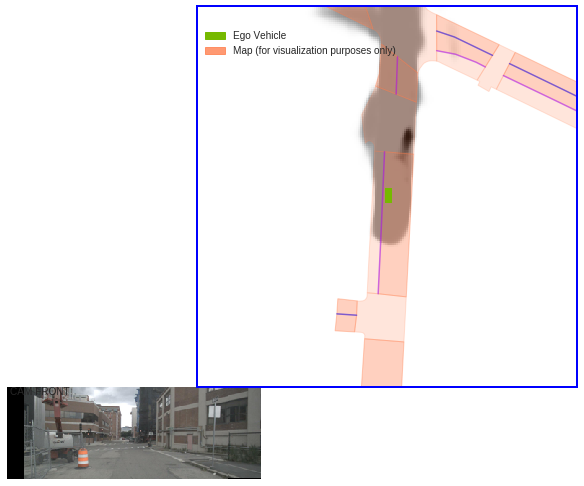

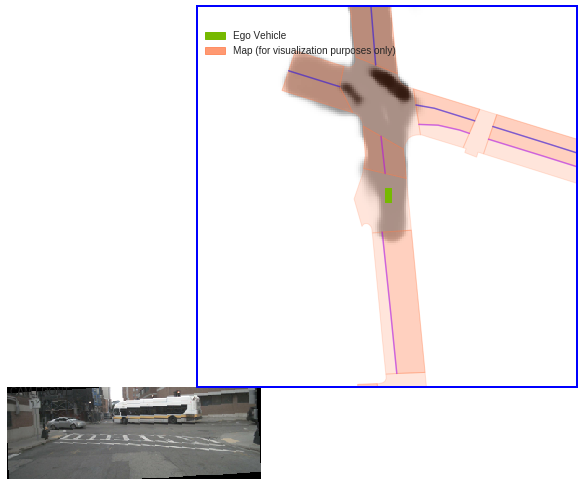

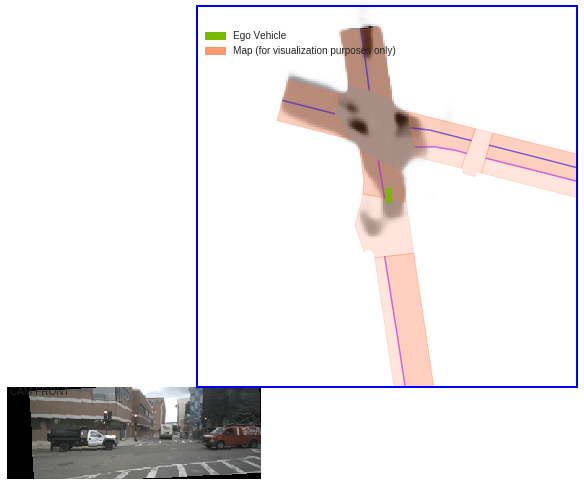

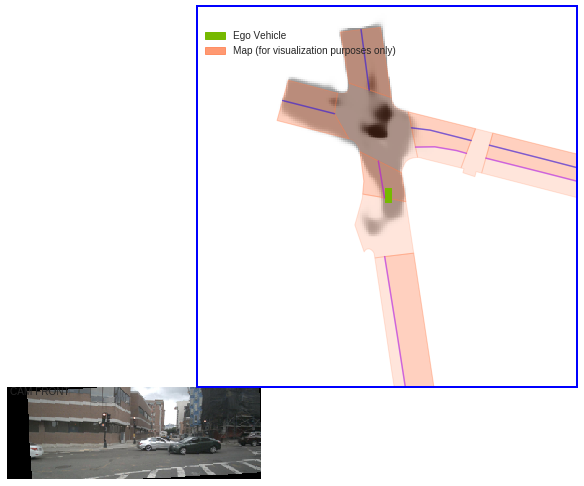

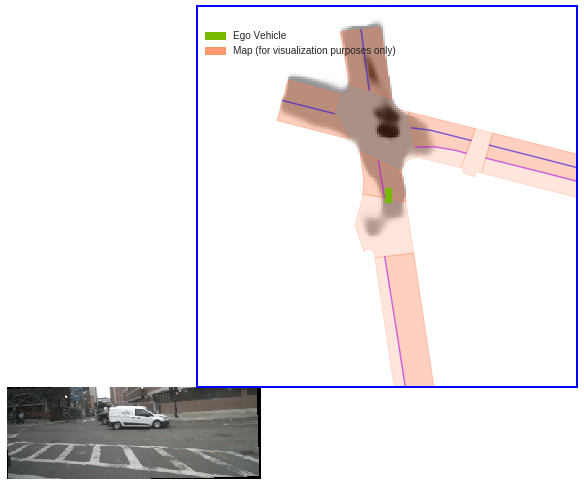

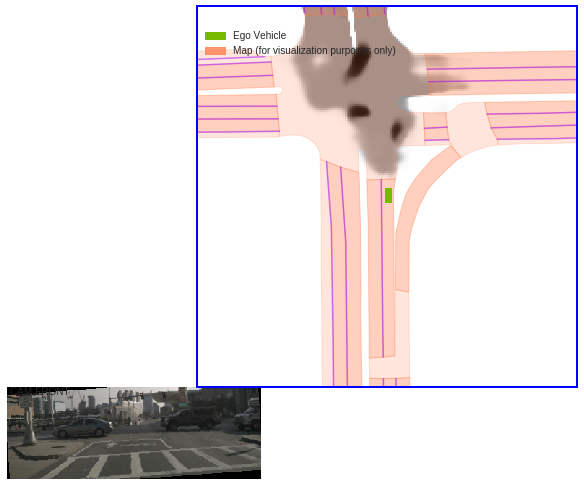

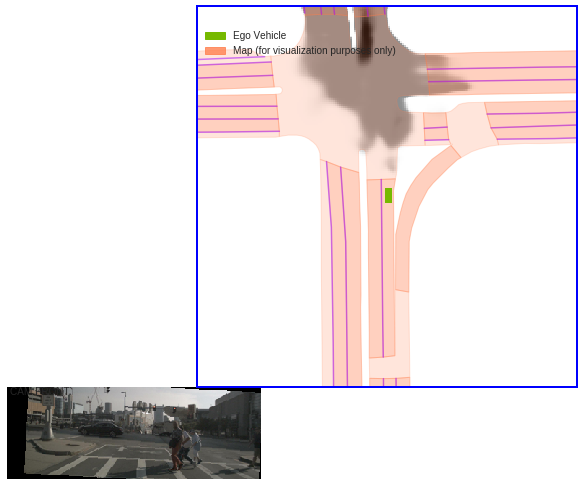

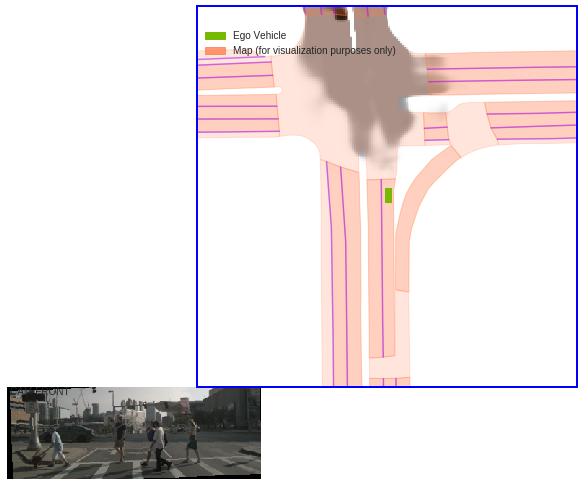

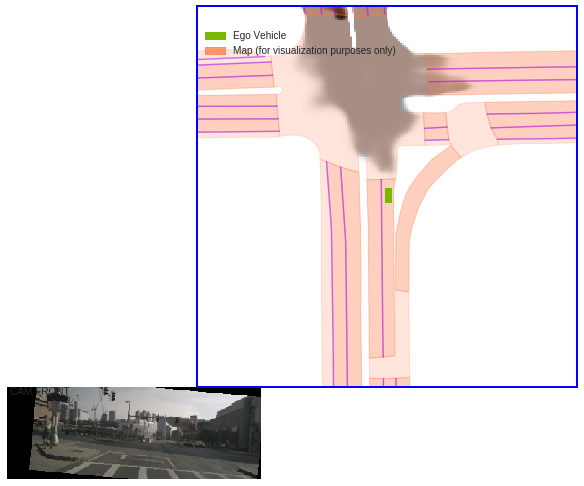

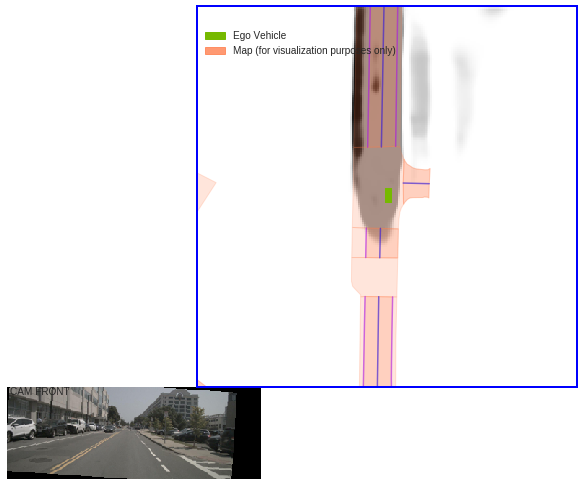

In [10]:
from src.tools import (ego_to_cam, get_only_in_img_mask, denormalize_img,
                    SimpleLoss, get_val_info, add_ego, gen_dx_bx,
                    get_nusc_maps, plot_nusc_map)
from PIL import Image
import matplotlib.patches as mpatches
%matplotlib inline

dx, bx, _ = gen_dx_bx(grid_conf['xbound'], grid_conf['ybound'], grid_conf['zbound'])
dx, bx = dx[:2].numpy(), bx[:2].numpy()

data = traindata

scene2map = {}
for scene in nusc.scene:
    log = nusc.get('log', scene['log_token'])
    scene2map[scene['name']] = log['location']

model.eval()

for counter in range(0, 100, 10):
    imgs, rots, trans, intrins, post_rots, post_trans, map_binimg = data[counter]
    
    # inference
    out = model(imgs.unsqueeze(0).to(device),
                rots.unsqueeze(0).to(device),
                trans.unsqueeze(0).to(device),
                intrins.unsqueeze(0).to(device),
                post_rots.unsqueeze(0).to(device),
                post_trans.unsqueeze(0).to(device),
                )
    out = out.sigmoid().cpu()

    val = 0.01
    fH, fW = final_dim
    fig = plt.figure(figsize=(3*fW*val, (1.5*fW + 2*fH)*val))
    gs = mpl.gridspec.GridSpec(3, 3, height_ratios=(1.5*fW, fH, fH))
    gs.update(wspace=0.0, hspace=0.0, left=0.0, right=1.0, top=1.0, bottom=0.0)

    plt.clf()
    for imgi, img in enumerate(imgs):
        ax = plt.subplot(gs[1 + imgi // 3, imgi % 3])
        showimg = denormalize_img(img)
        # flip the bottom images
        if imgi > 2:
            showimg = showimg.transpose(Image.FLIP_LEFT_RIGHT)
        plt.imshow(showimg)
        plt.axis('off')
        plt.annotate(cams[imgi].replace('_', ' '), (0.01, 0.92), xycoords='axes fraction')

    ax = plt.subplot(gs[0, :])
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    plt.setp(ax.spines.values(), color='b', linewidth=2)
    plt.legend(handles=[
        # mpatches.Patch(color=(0.0, 0.0, 1.0, 1.0), label='Output Vehicle Segmentation'),
        mpatches.Patch(color='#76b900', label='Ego Vehicle'),
        mpatches.Patch(color=(1.00, 0.50, 0.31, 0.8), label='Map (for visualization purposes only)')
    ], loc=(0.01, 0.86))

    # plot static map (improves visualization)
    rec = data.ixes[counter]
    drivable_area = out.squeeze(0)[0, ...]
    cars = out.squeeze(0)[1, ...]
    local_map = (drivable_area + cars).detach().clone()
    plt.imshow(local_map.squeeze(0))
    
    # visualize ground truth road map
    plot_nusc_map(rec, nusc_maps, nusc, scene2map, dx, bx)
    
    plt.xlim((data.nx[0], 0))
    plt.ylim((0, data.nx[1]))
    add_ego(bx, dx)

    plt.show()